In [1]:
from fastai.vision.all import *
import seaborn as sns


sns.set()


In [2]:
path = untar_data(URLs.PASCAL_2007)


In [3]:
df = pd.read_csv(path/'train.csv')
df.head()


,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


You can access rows and columns of a DataFrame with the iloc property, as if it were a matrix:

In [4]:
df.iloc[:, 0]


0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [5]:
df.iloc[0]


fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

You can also grab a column by name by indexing into a DataFrame directly:

In [6]:
df['fname']


0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

You can create new columns and do calculations using columns:

In [7]:
df1 = pd.DataFrame()
df1['a'] = [1, 2, 3, 4]
df1


,a
0,1
1,2
2,3
3,4


In [8]:
df1['b'] = [10, 20, 30, 40]
df1['a'] + df1['b']


0    11
1    22
2    33
3    44
dtype: int64

Let’s start with the simplest case, which is a data block created with no parameters

In [9]:
dblock = DataBlock()


We can create a Datasets object from this

In [10]:
dsets = dblock.datasets(df)


This contains a train and a valid dataset, which we can index into:

In [11]:
dsets.train[0]


(fname            000554.jpg
 labels      person sofa car
 is_valid              False
 Name: 275, dtype: object,
 fname            000554.jpg
 labels      person sofa car
 is_valid              False
 Name: 275, dtype: object)

As you can see, this simply returns a row of the DataFrame, twice. This is because
by default, the data block assumes we have two things: input and target

We are
going to need to grab the appropriate fields from the DataFrame, which we can do
by passing get_x and get_y functions:

In [12]:
dblock = DataBlock(get_x=lambda r: r['fname'],
                   get_y=lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]


('001843.jpg', 'bottle person')

In [13]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')


dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]


(Path('C:/Users/Vadim/.fastai/data/pascal_2007/train/002021.jpg'), ['cow'])

The problem is that block returns a single
integer, but we need to be able to have multiple labels for each item. To solve this,
we use a MultiCategoryBlock. This type of block expects to receive a list of
strings, as we have in this case, so let’s test it out:

In [14]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[4]


(PILImage mode=RGB size=375x500,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.]))

The reason we can’t easily just use a list of category indices is that each list would be a different length, and PyTorch requires tensors, where everything has
to be the same length.

Let’s check what the categories represent for this example (we are using the
convenient torch.where function, which tells us all of the indices where our
condition is true or false)

In [15]:
idxs = torch.where(dsets.train[4][1] == 1,)[0]
dsets.train.vocab[idxs]


(#1) ['pottedplant']

In [16]:
arr = list(range(10))


In [17]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid


In [18]:

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y)


In [19]:
dsets = dblock.datasets(df)
dsets.train[4]


(PILImage mode=RGB size=500x281,
 TensorMultiCategory([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.]))

In [20]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


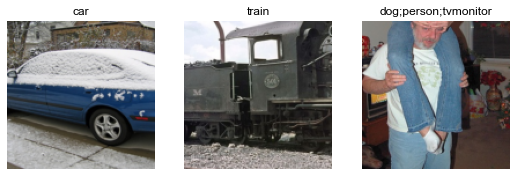

In [21]:
dls.show_batch(nrows=1, ncols=3)
